In [ ]:
import pyreadr
from geopy.distance import geodesic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import cartopy.crs as ccrs
import cartopy
import cartopy.io.shapereader as shpreader
#import cartopy.feature as cfeature

result = pyreadr.read_r('cities.rds')
dataset=result[None]
dataset

,name,country.etc,pop,lat,long,capital,max_pop,full.name
0,Aba,Nigeria,931872,5.10,7.35,0.0,9020089,"Aba, Nigeria"
1,Abadan,Iran,415139,30.33,48.28,0.0,7160094,"Abadan, Iran"
2,Abeokuta,Nigeria,612277,7.16,3.35,0.0,9020089,"Abeokuta, Nigeria"
3,Abidjan,Ivory Coast,3796677,5.33,-4.03,0.0,3796677,"Abidjan, Ivory Coast"
4,Abomey-Calavi,Benin,413812,6.44,2.36,0.0,701137,"Abomey-Calavi, Benin"
...,...,...,...,...,...,...,...,...
1245,Zaporizhzhya,Ukraine,791626,47.85,35.17,0.0,2491404,"Zaporizhzhya, Ukraine"
1246,Zaragoza,Spain,658186,41.65,-0.89,0.0,3146804,"Zaragoza, Spain"
1247,Zaria,Nigeria,998032,11.08,7.71,0.0,9020089,"Zaria, Nigeria"
1248,Zhengzhou,China,2023495,34.75,113.67,0.0,15017783,"Zhengzhou, China"


## choose 100 random cities with the corresponding coordinates

In [ ]:
det_coord_cities=[(dataset.loc[i]['lat'],dataset.loc[i]['long']) for i in range(0,1250)]
det_coordinate=dict(zip([i for i in range(0,1250)],det_coord_cities))

In [ ]:
coord_cities=[]
i=0
while i<100:
    r=random.choice(det_coord_cities)
    if r not in coord_cities:
        coord_cities.append(r)
    else:
        continue
    i+=1
coordinate=dict(zip([i for i in range(0,100)],coord_cities))

## useful functions

In [ ]:
#geodedic distance
def d(città1_coord,città2_coord):
    return geodesic(città1_coord,città2_coord).km


#let's define the path's "energy": the "energy" in this case is the path's lenght that is the cost function to minimize
def Energia(lista):
    En=0
    i=0
    while i<=len(lista)-2:
        add=d(coordinate[lista[i]],coordinate[lista[i+1]])
        En+=add
        i+=1
    
    ultimate_add=d(coordinate[lista[-1]],coordinate[lista[0]])
    En+=ultimate_add
    return En    

#probability to accept the new state
def P(E1,E2,T):
    k=10**3
    return np.exp(-(E2-E1)/(k*T))


#how to generate a new state from the current state

def newstate(actual_state):
    ns=actual_state[:]
    random_cities = random.sample([i for i in range(1,len(ns))],2) #choice two random cities by their indices (here the first city is fixed)
    blocco=ns[min(random_cities)+1:max(random_cities)] #take the block between the two randomly chosen cities
    blocco.reverse() #reverse the block
    
    #insert the reversed block
    ns[min(random_cities)+1:max(random_cities)]=[] 
    ns[min(random_cities)+1:min(random_cities)+1]=blocco
    return ns


def newstatetot(actual_state):
    ns=actual_state[:]
    random_cities = random.sample([i for i in range(-1,len(ns))],2) #choice two random cities by their indices (here the first city can change)
    blocco=ns[min(random_cities)+1:max(random_cities)] #take the block between the two randomly chosen cities
    blocco.reverse() #reverse the block
    
    #insert the reversed block
    ns[min(random_cities)+1:max(random_cities)]=[] 
    ns[min(random_cities)+1:min(random_cities)+1]=blocco
    return ns

## Let's writing the simulated annealing algorithm

In [ ]:
#initial random state
S0=[i for i in range(0,100)] 
random.shuffle(S0)
Energia(S0)

#start the simulation

T=100. #initial temperature (for this temperature the 80% of states are accepted)
T_fmin=10**(-30) #minimal possible temperature to reach
energia=[] #vettore delle energie, prime 4 di default. Ogni energia corrisponde a una certa temperatura
T_t=[] 
E_t=[] 
T_iter=[]#list of temperature for each iteration
E_iter=[] #list of energy for each iteration

#let's build the vector of all possible temperaturer
a=0.95 #cooling coefficient
temperature=[T]
t=T
while t>T_fmin:
    temperature.append(t*a)
    t=t*a
    
E_minimal=[] #corresponding energy for minima we have found
stati=[] #minima we have found

it=0 #iterations numbers
n=0
itermax=0
while n<len(temperature)-1: #for each temperature
    print('actual temperature:',temperature[n]) #actual temperature
    print('energy:',Energia(S0)) #actual energy
    T_t.append(temperature[n])
    E_t.append(Energia(S0))
    energia.append(Energia(S0))
    if len(energia)>4:
        if energia[-1]==energia[-2]==energia[-3]==energia[-4]:
            if itermax<3: #maximum number of times we can raise the temperature (it has so be choosen, in this case we choose 3 times)
                itermax+=1
                E_minimal.append(energia[-1])
                stati.append(S0)
                n=n-21 #raise the temperature
                print('RAISE THE TEMPERATURE')
                print(f'the next temperature will be: T={temperature[n]}')
            else:
                print('the temperature has already been raised up 10 times, STOP')
                break
            
    
            
    A=0. #number of states accepted
    R=0. #numer of states refused
    count=0
    
    #let's create the first new state
    
    it+=1 #update number of iterations
    T_iter.append(temperature[n])
    
    s=newstate(S0) #new state
    e=Energia(s)
    if e-Energia(S0)<0:
        #print(f'{e}: yes')
        A+=1
        S0=s
        
        E_iter.append(e)
        
    else:
        alpha=random.uniform(0,1)
        if alpha<P(Energia(S0),e,temperature[n]):
            #print(f'{e}: {P(Energia(S0),e,temperature[n])}---->',alpha<P(Energia(S0),e,temperature[n]))
            A+=1
            S0=s
            
            E_iter.append(e)
            
        else:
            S0=S0
            R+=1
            
            E_iter.append(Energia(S0))
            
    while R<=1: #until we get at least 1 refused state
        
        it+=1 #update number of iterations
        T_iter.append(temperature[n])

        s=newstate(S0) #new state
        e=Energia(s)
        if e-Energia(S0)<0:
            #print(f'{e}: yes')
            A+=1
            S0=s
        
            E_iter.append(e)
        
        else:
            alpha=random.uniform(0,1)
            if alpha<P(Energia(S0),e,temperature[n]):
                #print(f'{e}: {P(Energia(S0),e,temperature[n])}---->',alpha<P(Energia(S0),e,temperature[n]))
                A+=1
                S0=s
            
                E_iter.append(e)
            
            else:
                S0=S0
                R+=1
            
                E_iter.append(Energia(S0))
        R=R
        
        
    k=A/R
    ek=[]
    while k<=3./10.: #stop criterion
            
        it+=1 #update number of iterations
        T_iter.append(temperature[n])
   
        s=newstatetot(S0) # new state
        e=Energia(s)
        if e-Energia(S0)<0:
            #print(f'{e}: yes')
            A+=1
            S0=s
            ek.append(e)    
            E_iter.append(e)
                
        else:
            alpha=random.uniform(0,1)
            if alpha<P(Energia(S0),e,temperature[n]):
                #print(f'{e}: {P(Energia(S0),e,temperature[n])}---->',alpha<P(Energia(S0),e,temperature[n]))
                A+=1
                S0=s
                ek.append(e)    
                E_iter.append(e)
                    
            else:
                S0=S0
                R+=1
                    
                E_iter.append(Energia(S0))

                    
        count+=1
        if count>10**(3): 
            print('maximum iterations reached')
            break
        k=A/R
    print('next temperature===============================================================================')
    n+=1
    
dizionario=dict(zip(E_minimal,stati)) #for each energy, the corresponding path
print(dizionario)

## Let's see the best path and its energy

In [ ]:
percorso=S0
percorso=percorso+[percorso[0]]
print(f'percorso: {percorso}')
print(f'energia: {Energia(percorso)}')

percorso: [73, 97, 61, 64, 67, 7, 91, 36, 59, 31, 94, 78, 14, 55, 26, 12, 0, 98, 48, 75, 58, 27, 24, 17, 83, 44, 84, 1, 53, 25, 87, 51, 21, 29, 35, 10, 45, 70, 85, 3, 4, 60, 49, 8, 93, 76, 9, 50, 54, 80, 42, 52, 72, 6, 15, 82, 5, 33, 57, 30, 2, 88, 56, 69, 19, 96, 20, 28, 95, 86, 77, 34, 18, 66, 99, 65, 43, 22, 81, 92, 11, 37, 62, 68, 39, 63, 32, 47, 38, 89, 40, 46, 71, 13, 16, 41, 90, 79, 23, 74, 73]
energia: 118557.54014473462


## Visualizing path on map

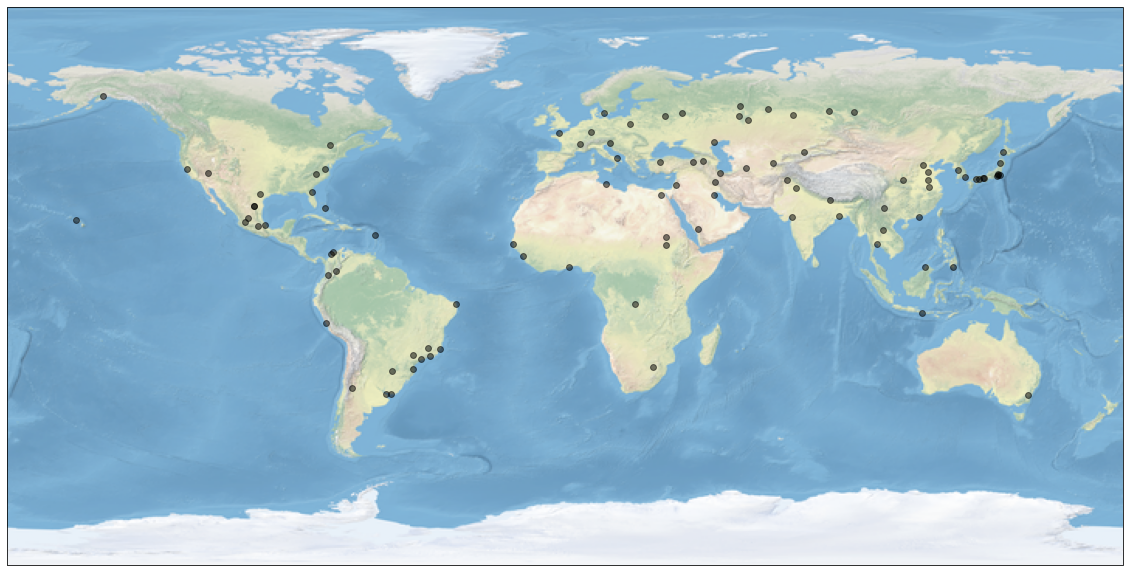

In [ ]:
plt.figure(figsize=(20, 20))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
#ax.coastlines()
#ax.add_feature(cfeature.BORDERS)



plt.scatter(x=[list(coordinate[percorso[i]])[1] for i in range(0,100)], y=[list(coordinate[percorso[i]])[0] for i in range(0,100)],
            color="black",
            s=35,
            alpha=0.5,
            transform=ccrs.PlateCarree())
plt.show()

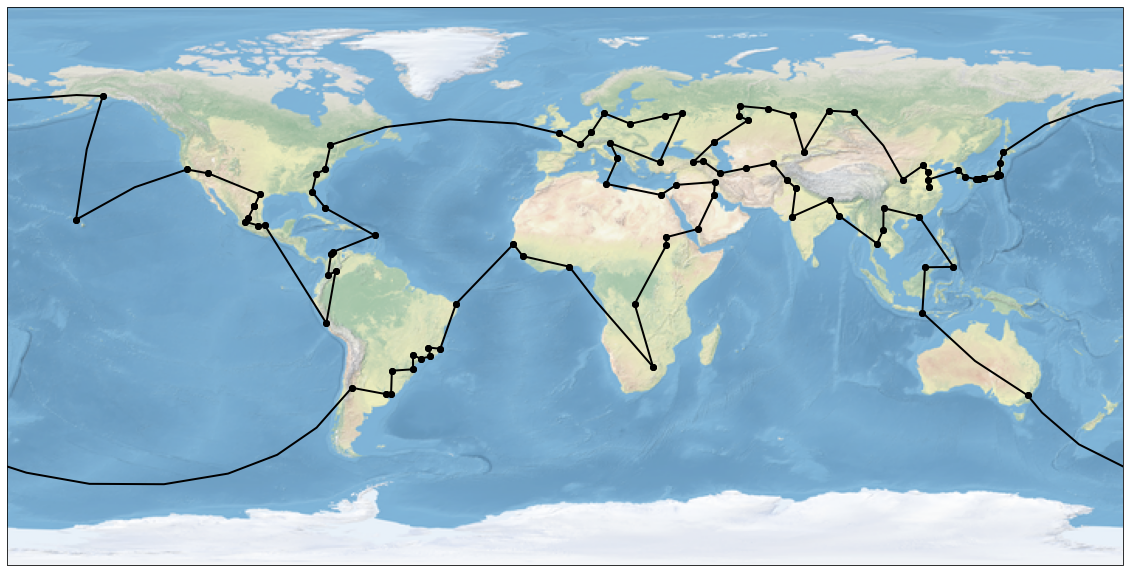

In [ ]:
plt.figure(figsize=(20, 20))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()



for i in range(0,100):
    plt.plot([list(coordinate[percorso[i]])[1],list(coordinate[percorso[i+1]])[1]],
             [list(coordinate[percorso[i]])[0],list(coordinate[percorso[i+1]])[0]],
         color='black', linewidth=2, marker='o',
         transform=ccrs.Geodetic())

plt.show()

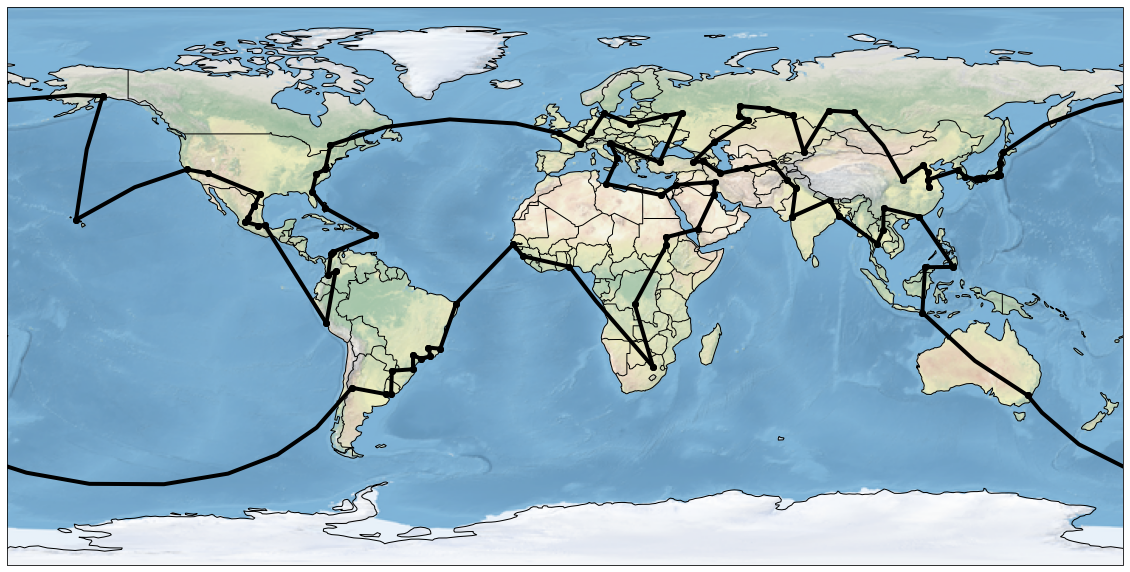

In [ ]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

ax.stock_img()
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
for i in range(0,100):
    plt.plot([list(coordinate[percorso[i]])[1],list(coordinate[percorso[i+1]])[1]],
             [list(coordinate[percorso[i]])[0],list(coordinate[percorso[i+1]])[0]],
         color='black', linewidth=4, marker='o',
         transform=ccrs.Geodetic())
plt.show()


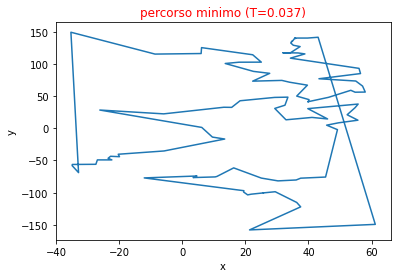

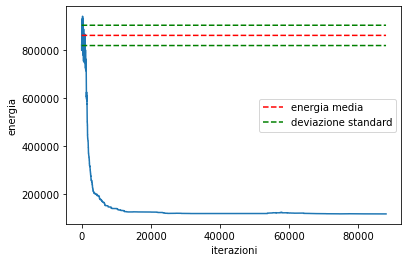

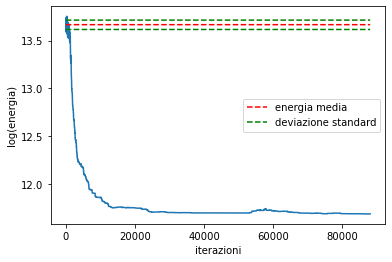

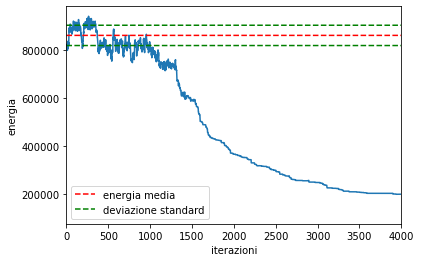

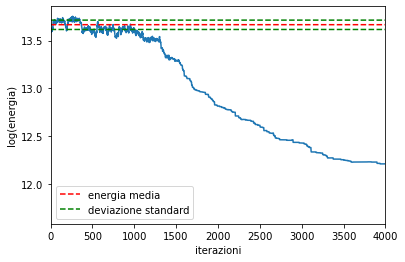

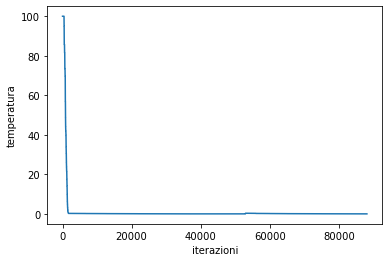

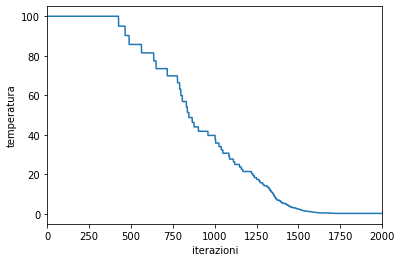

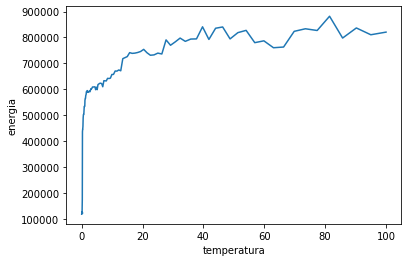

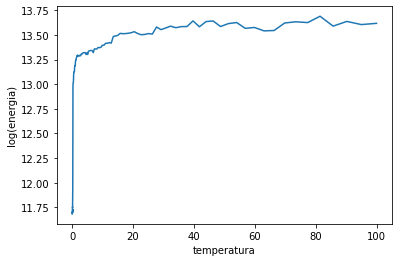

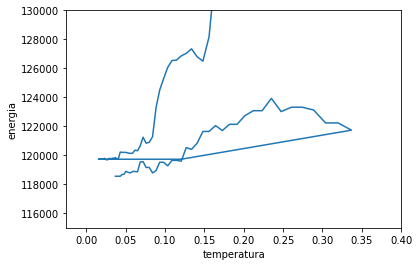

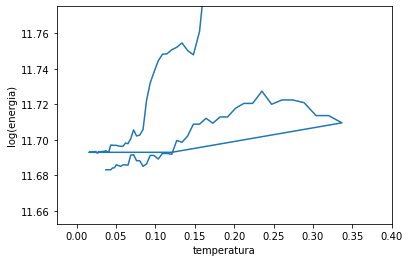

In [ ]:
ET=dict(zip(E_t,T_t))
EI=dict(zip(E_iter,[i for i in range(0,it)]))

xi=[coordinate[p][0] for p in percorso]
yi=[coordinate[p][1] for p in percorso]
plt.plot(xi,yi)
#plt.scatter(x,y,marker='x')
plt.title('percorso minimo (T=%.3f)' %(ET[min(E_t)]),color='r')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#let's compute the mean energy on random path

e_=[]
p=[i for i in range(0,100)] 
for n in range(100):
    random.shuffle(p)
    e_.append(Energia(p)) #energy of random path
emean=np.mean(np.array(e_)) #mean energy
estd=np.std(np.array(e_))

plt.plot([i for i in range(0,it)],E_iter)
#plt.xlim(0,2000)
plt.plot([i for i in range(0,it)],[emean for i in range(0,it)],'--',color='r',label='energia media')
plt.plot([i for i in range(0,it)],[emean+estd for i in range(0,it)],'--',color='g',label='deviazione standard')
plt.plot([i for i in range(0,it)],[emean-estd for i in range(0,it)],'--',color='g')
plt.legend()
plt.xlabel('iterazioni')
plt.ylabel('energia')
plt.show()

plt.plot([i for i in range(0,it)],np.log(E_iter))
#plt.xlim(0,2000)
plt.plot([i for i in range(0,it)],[np.log(emean) for i in range(0,it)],'--',color='r',label='energia media')
plt.plot([i for i in range(0,it)],[np.log(emean+estd) for i in range(0,it)],'--',color='g',label='deviazione standard')
plt.plot([i for i in range(0,it)],[np.log(emean-estd) for i in range(0,it)],'--',color='g')
plt.legend()
plt.xlabel('iterazioni')
plt.ylabel('log(energia)')
plt.show()

plt.plot([i for i in range(0,it)],E_iter)
plt.xlim(0,4000)
plt.plot([i for i in range(0,it)],[emean for i in range(0,it)],'--',color='r',label='energia media')
plt.plot([i for i in range(0,it)],[emean+estd for i in range(0,it)],'--',color='g',label='deviazione standard')
plt.plot([i for i in range(0,it)],[emean-estd for i in range(0,it)],'--',color='g')
plt.legend()
plt.xlabel('iterazioni')
plt.ylabel('energia')
plt.show()

plt.plot([i for i in range(0,it)],np.log(E_iter))
plt.xlim(0,4000)
plt.plot([i for i in range(0,it)],[np.log(emean) for i in range(0,it)],'--',color='r',label='energia media')
plt.plot([i for i in range(0,it)],[np.log(emean+estd) for i in range(0,it)],'--',color='g',label='deviazione standard')
plt.plot([i for i in range(0,it)],[np.log(emean-estd) for i in range(0,it)],'--',color='g')
plt.legend()
plt.xlabel('iterazioni')
plt.ylabel('log(energia)')
plt.show()


plt.plot([i for i in range(0,it)],T_iter)
plt.xlabel('iterazioni')
plt.ylabel('temperatura')
plt.show()

plt.plot([i for i in range(0,it)],T_iter)
plt.xlim(0,2000)
plt.xlabel('iterazioni')
plt.ylabel('temperatura')
plt.show()

plt.plot(T_t,E_t)
plt.xlabel('temperatura')
plt.ylabel('energia')
plt.show()

plt.plot(T_t,np.log(E_t))
plt.xlabel('temperatura')
plt.ylabel('log(energia)')
plt.show()


plt.plot(T_t,E_t)
plt.xlim(-0.025,0.4)
plt.ylim(115000,130000)
plt.xlabel('temperatura')
plt.ylabel('energia')
plt.show()

plt.plot(T_t,np.log(E_t))
plt.xlim(-0.025,0.4)
plt.ylim(np.log(115000),np.log(130000))
plt.xlabel('temperatura')
plt.ylabel('log(energia)')
plt.show()

